In [1]:
using LinearAlgebra
using Plots
using Printf
using OffsetArrays
using Integrals
using StaticArrays

In [2]:
@enum FlaxMethod LaxFriedrichs Godunov #Roe # HLL HLLC
@enum BoundaryCondition Reflecting Extrapolate # Periodic
@enum SlopeLimiter Minmod VanLeer Superbee

In [186]:
v = collect(1:3)
v

3-element Vector{Int64}:
 1
 2
 3

In [187]:
v[end]

3

In [190]:
a = OffsetArray(v, -1)
a

3-element OffsetArray(::Vector{Int64}, 0:2) with eltype Int64 with indices 0:2:
 1
 2
 3

In [193]:
a[end+1]

BoundsError: BoundsError: attempt to access 3-element OffsetArray(::Vector{Int64}, 0:2) with eltype Int64 with indices 0:2 at index [3]

In [ ]:
struct OutputData
    q::Vector{SVector}
    t::Float64
    x::Vector{Float64}
end



function apply_boundary_condition!(q, bc, nbc; u_index=0)
    if bc == Reflecting
        for i in 1:nbc
            q[1-i] = q[i]
            q[1-i] =  setindex(q[1-i], -q[1-i][u_index], u_index) 
            # q[end-i] = q[end -i + 1 -nbc]
            q[end] = q[end+12]
            # q[end+i] = setindex(q[end + 1], -q[end+i][u_index], u_index) 
        end
        
    elseif bc == Extrapolate
        for i in 1:nbc
            q[1-i] = q[1]
            q[end-i+1] = q[end - i]
        end
    end
end


function rs(q, i, A::AbstractMatrix, dx, dt)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    λ, R = eigen(A)
    R_inv = inv(R)

    Ap = R * diagm(max.(λ, 0)) * R_inv
    Am = R * diagm(min.(λ, 0)) * R_inv


    return q[i] - dt/dx * (Ap * dqm + Am * dqp) 
end

function rs(q, i, A::Number, dx, dt)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    Ap = max(A, 0)
    Am = min(A, 0)

    return q[i] - dt/dx * (Ap * dqm + Am * dqp) 
end


function evolve(q, i, A, dt, dx, method)
   if method == LaxFriedrichs
        return (q[i-1] + q[i+1])/2  - dt/dx * ( A * q[i]  - A*q[i-1])
    elseif method == Godunov
       return rs(q, i, A, dx, dt)
    end
end

function minmod(a, b, dx)
    if a*b < 0
        return 0
    else
        return sign(a) * min(abs(a), abs(b))
    end
end

function reconstruct(q, i, slope, dx)
    if slope == Minmod
        return minmod(q[i] - q[i-1], q[i+1] - q[i], dx)
    else 
        return  q
    end
end

function solve(A, a, b, dx , dt, tmax, g_initial; method=Godunov, log_interval=0, boundary_condition=Extrapolate, u_index=0)
    
    # hardcoded boundary condition for now
    # 2 ghost cells front and back
    ngc = 2

    N = Int((b-a)/dx)+1

    ndim = length(g_initial(a))
    # initiliaze grid

        
    q0 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)
    q1 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)

    @printf("N = %d\n", N)
    # improve later on

    for i in 1:N
        iv =  g_initial(a + (i-1)*dx)
        if isa(iv, Number)
            q0[i] = @SVector [iv]
        else
            q0[i] = iv
        end
    end


    x = collect(a:dx:b)
    τ = 0
    last_log = 0

    output = [OutputData(q0[1:N], τ, x)]

    # Linear constant coefficient problems for now
    while τ < tmax
        # boundary condition
        apply_boundary_condition!(q0, boundary_condition, ngc; u_index=u_index)

        for i in 1:N
            
            # reconstruction

            # evolution

            q1[i] = evolve(q0, i, A, dt, dx, method)
            # Averaging
            
            # todo check CFL condition

        end

        # log
        if log_interval > 0 && τ - last_log > log_interval
            push!(output, OutputData(q1[1:N], τ, x))
            last_log = τ
        end

        # swap states
        q0, q1 = q1, q0
   
        τ += dt
    end

    push!(output, OutputData(q1[1:N], τ, x))
    return output
end




solve (generic function with 3 methods)

In [153]:
g_ind(x, a, b) = if (x > a && x < b) 1 else 0 end

g_initial(x) = exp(-200*(x-0.3)^2)  + g_ind(x, 0.6, 0.8)

g_initial (generic function with 1 method)

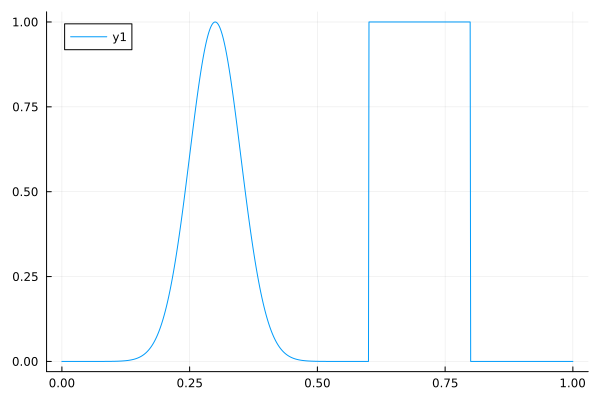

In [154]:
x = 0:0.001:1
plot(x, g_initial.(x))

In [201]:
u = 1
a = 0
b = 2
dx = 0.01
dt = 0.001

sol = solve(u, a, b, dx , dt, 1.5, g_initial; method=Godunov, log_interval=dt, boundary_condition=Reflecting, u_index=1)

N = 201


BoundsError: BoundsError: attempt to access 205-element OffsetArray(::Vector{SVector{1, Float64}}, -1:203) with eltype SVector{1, Float64} with indices -1:203 at index [204]

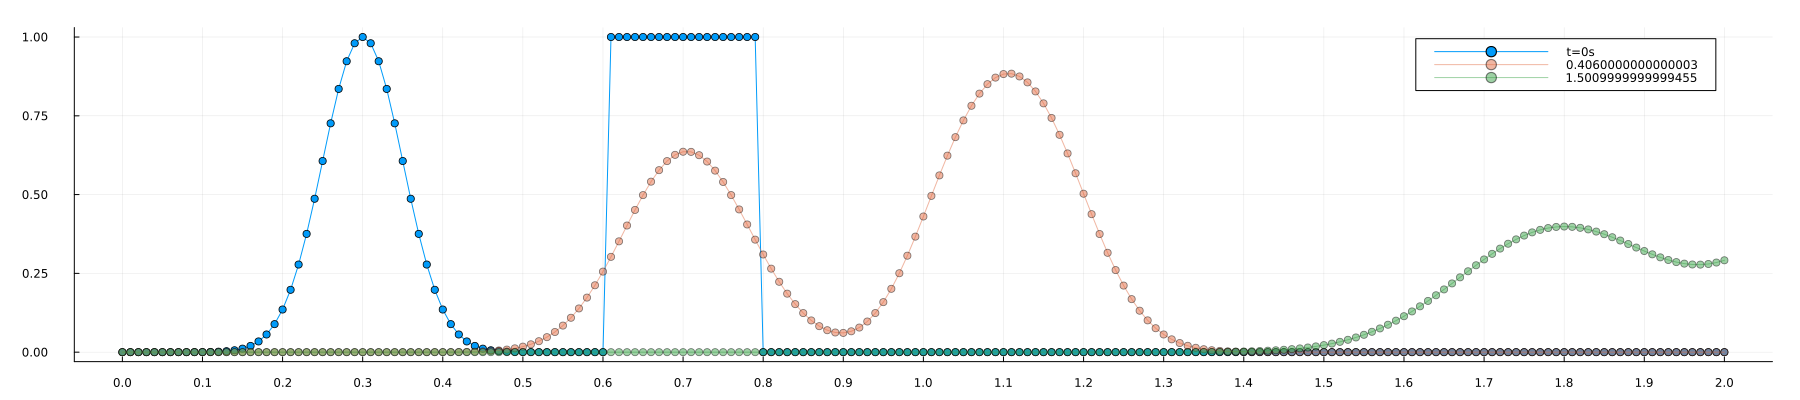

In [180]:
using Plots.PlotMeasures

n = 400
t = n * dt
x = a:dx:b

plot(sol[1].x, first.(sol[1].q), marker=:circle, label="t=0s", size=(1800, 400), margin=5mm, xticks=0:0.1:2)
plot!(sol[n].x, first.(sol[n].q), marker=:circle, label="$(sol[n].t)", opacity=0.5)
plot!(sol[end].x, first.(sol[end].q), marker=:circle, label="$(sol[end].t)", opacity=0.5)

N = 201


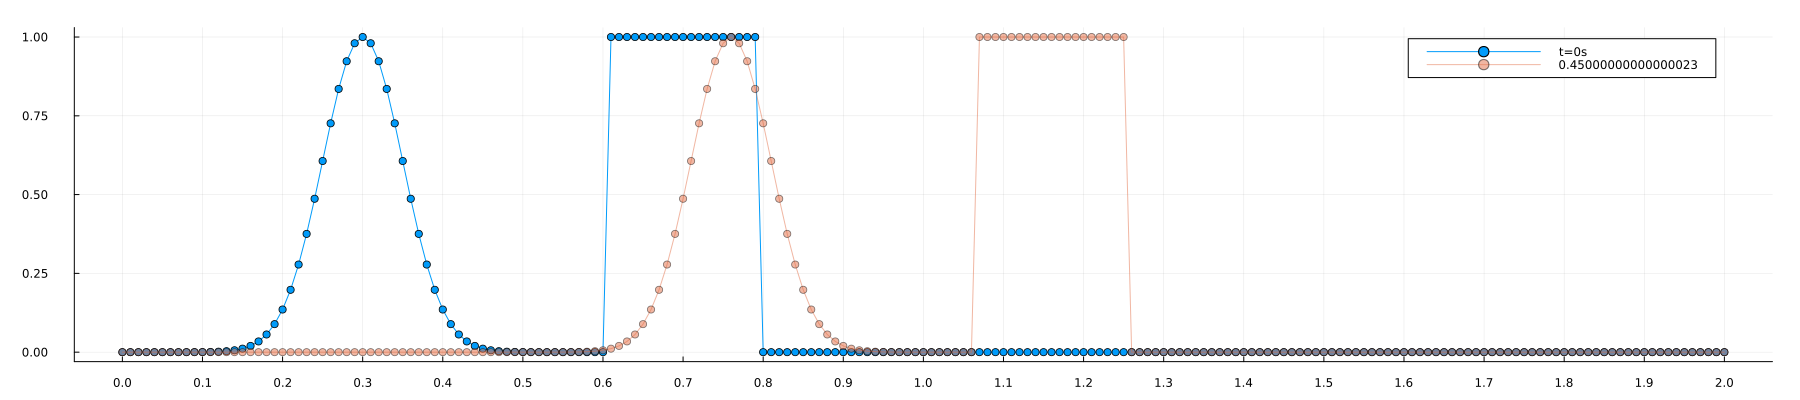

In [120]:
CFL = 1/2 

u_cfl = 1
a_cfl = 0
b_cfl = 2
dx_cfl = 0.01
dt_cfl = 0.01


n = 40
t = n * dt_cfl 

sol_cfl = solve(u_cfl, a_cfl, b_cfl, dx_cfl , dt_cfl, 4, g_initial; method=Godunov, log_interval=dt_cfl)

plot(sol_cfl[n].x, first.(sol_cfl[1].q), marker=:circle, label="t=0s", size=(1800, 400), margin=5mm, xticks=0:0.1:2)
plot!(sol_cfl[n].x, first.(sol_cfl[n].q), marker=:circle, label="$(sol_cfl[n].t)", opacity=0.5)

In [121]:
p_0(x) = exp(-80*x^2)/2 + g_ind(x, -0.3, -0.1)
u_0(x) = 0 
q_0(x) = [p_0(x), u_0(x)]

q_0 (generic function with 1 method)

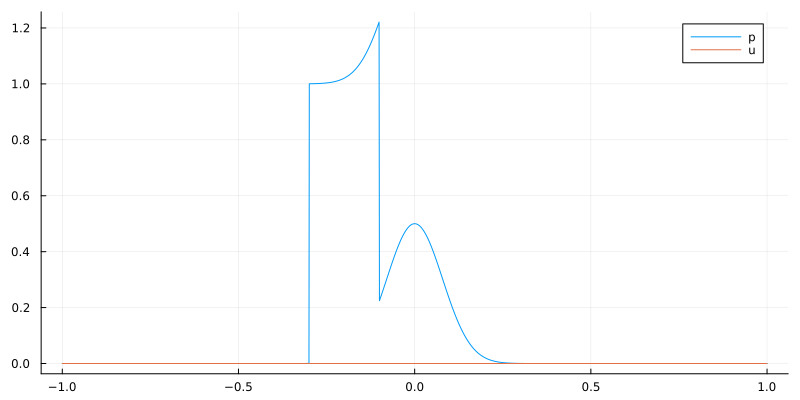

In [122]:
x = -1:0.001:1
plot(x, p_0.(x), label="p", size=(800, 400))
plot!(x, u_0.(x), label="u")

In [123]:
po = 1
Ko = 0.25

A =    [0 Ko; 1/po 0]
dx = 0.01 
dt = 0.01
tmax = 2
method = Godunov



sol_acc = solve(A, -1, 1, dx , dt, tmax, q_0; method=Godunov, log_interval=0.1)


N = 201


21-element Vector{OutputData}:
 OutputData(SVector[[9.024256939227076e-36, 0.0], [4.434128423968185e-35, 0.0], [2.1441559560061996e-34, 0.0], [1.020365491633119e-33, 0.0], [4.778663420419642e-33, 0.0], [2.2024619332469147e-32, 0.0], [9.989912114251356e-32, 0.0], [4.459295091268569e-31, 0.0], [1.958944111113027e-30, 0.0], [8.468942168123125e-30, 0.0]  …  [8.468942168123005e-30, 0.0], [1.9589441111130548e-30, 0.0], [4.459295091268569e-31, 0.0], [9.989912114251356e-32, 0.0], [2.2024619332469147e-32, 0.0], [4.778663420419642e-33, 0.0], [1.020365491633119e-33, 0.0], [2.1441559560061996e-34, 0.0], [4.434128423968185e-35, 0.0], [9.024256939227076e-36, 0.0]], 0.0, [-1.0, -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92, -0.91  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
 OutputData(SVector[[9.89819890194844e-31, -1.9796217318758102e-30], [4.164080152528339e-30, -8.32814223929816e-30], [1.7247903080317796e-29, -3.449578780489728e-29], [7.034104985900734e-29, -1.40682078

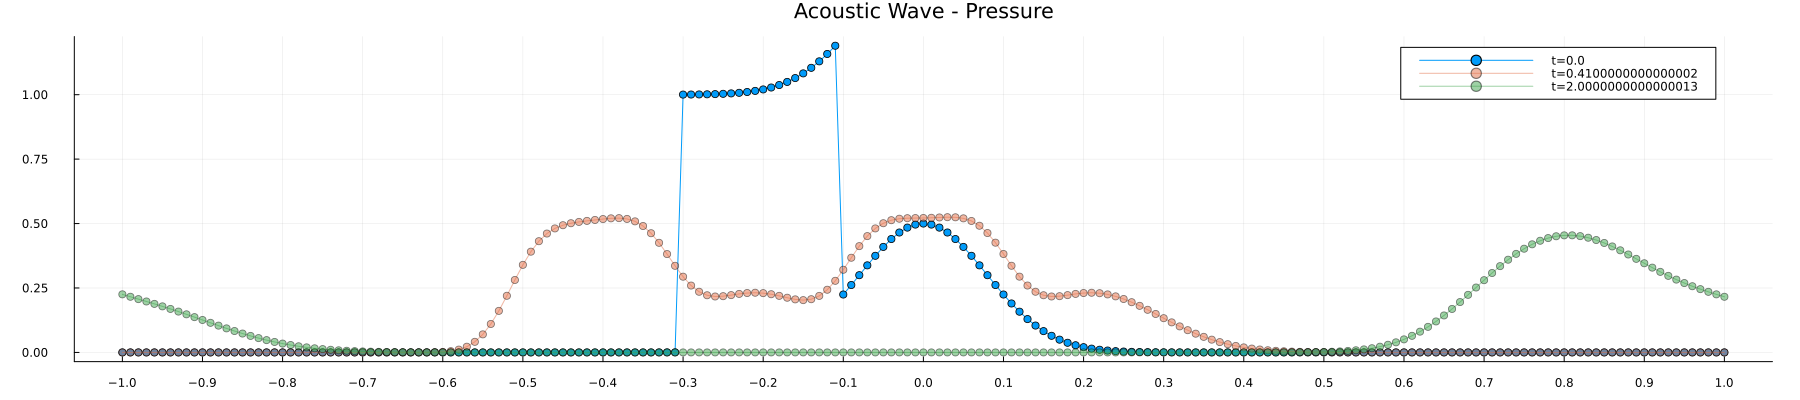

MethodError: MethodError: no method matching length(::OutputData)
The function `length` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  length(!Matched::Base.MethodSpecializations)
   @ Base reflection.jl:1317
  length(!Matched::Distributions.VonMisesFisherSampler)
   @ Distributions C:\Users\marko\.julia\packages\Distributions\tQhJE\src\samplers\vonmisesfisher.jl:20
  length(!Matched::Combinatorics.IntegerPartitions)
   @ Combinatorics C:\Users\marko\.julia\packages\Combinatorics\Udg6X\src\partitions.jl:17
  ...


In [127]:
fig1 = plot(sol_acc[1].x, first.(sol_acc[1].q), marker=:circle, label="t=$(sol_acc[1].t)", size=(1800, 400), margin=5mm, xticks=-1:0.1:1, title="Acoustic Wave - Pressure")
plot!(sol_acc[5].x, first.(sol_acc[5].q), marker=:circle, label="t=$(sol_acc[5].t)", opacity=0.5)
plot!(sol_acc[end].x, first.(sol_acc[end].q), marker=:circle, label="t=$(sol_acc[end].t)", opacity=0.5)

display(fig1)

fig2 = plot(sol_acc[1].x, getindex.(sol_acc[1], 2), marker=:circle, label="t=$(sol_acc[1].t)", size=(1800, 400), margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Velocity")
plot!(sol_acc[5].x, getindex.(sol_acc[5], 2), marker=:circle, label="t=$(sol_acc[5].t)", opacity=0.5)
plot!(sol_acc[end].x, getindex.(sol_acc[end], 2), marker=:circle, label="t=$(sol_acc[end].t)", opacity=0.5)
display(fig2)

In [31]:
length(q_0(0))

2

In [32]:
size(q_0(0))

(2,)

In [33]:
ndims(q_0(0))

1